In [1]:
from jax.numpy import arange, exp, sin, array, pi
from ticktack import load_presaved_model
import matplotlib.pyplot as plt

In [2]:
UNIT_FACTOR = 14.003242 / 6.022 * 5.11 * 31536. / 1.e5
PRODUCTION_RATE = 1.76

`jax.lax.scan` will let me make the most of the notes.

In [3]:
from jax.lax import scan 
from functools import partial 

In [4]:
def odeint_linear(derivative, y0, timesteps, *args, **kwargs):
    step_size = timesteps[1] - timesteps[0]

    def step(y, time_value, step_size=None, derivative=None, ):
        next_time_value = y + derivative(y, time_value) * step_size
        return next_time_value, next_time_value

    step = partial(step, derivative=derivative, step_size=step_size)

    _, y_values = scan(f=step, init=y0, xs=timesteps) 
    return y_values

In [5]:
def production(t, *args, steady_state=PRODUCTION_RATE):
    start, duration, phase, area = array(list(args)).reshape(-1)

    middle = start + duration / 2.
    height = area / duration
    gaussian = height * exp(- ((t - middle) / (duration / 2)) ** 16.)
    sinusoid = 0.18 * steady_state * sin(2 * pi / 11 * t + phase)
    production = gaussian + sinusoid + steady_state
    
    return UNIT_FACTOR * production

In [6]:
carbon_box_model = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
carbon_box_model.compile()

In [7]:
time_out = arange(-225, 775)
oversample = 1008
parameters = (774.86, 0.25, 0.8, 6.44)
growth_season = array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0])

In [8]:
_, y_initial = carbon_box_model.run(time_out, oversample, production, \
    args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

In [9]:
time_out = arange(750, 800)

In [10]:
odeint, _ = carbon_box_model.run(time_out, oversample, production,\
    y0=y_initial, args=parameters, steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)

odeint = odeint[:, 1]
odeint = carbon_box_model.bin_data(odeint, oversample, time_out, growth=array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=bool))

In [11]:
linode_oversample = {
    10: None,
    100: None,
    1000: None
}

for oversample in [10, 100, 1000]:
    linode, _ = carbon_box_model.run(time_out, oversample, \
        production, solver=odeint_linear, y0=y_initial, args=parameters, \
        steady_state_production=PRODUCTION_RATE * UNIT_FACTOR)
    
    linode = linode[:, 1]
    linode = carbon_box_model.bin_data(linode, oversample, time_out,\
        growth=array([0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0], dtype=bool))
    linode_oversample[oversample] = linode
    del linode

Text(0.5, 1.0, 'Linear vs DP5')

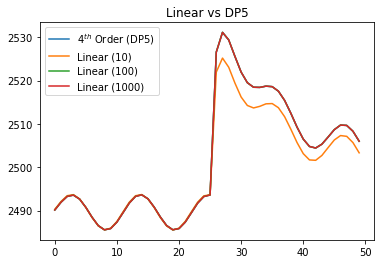

In [13]:
plt.plot(odeint)
plt.plot(linode_oversample[10])
plt.plot(linode_oversample[100])
plt.plot(linode_oversample[1000])
plt.legend(["$4^{th}$ Order (DP5)", "Linear (10)", "Linear (100)", "Linear (1000)"])
plt.title("Linear vs DP5")